# Use basic ML methods for img recognition
by Jenny Zeng

In [1]:
%pylab inline
import mltools as ml
plt.style.use('ggplot')
from sklearn.learning_curve import validation_curve
from sklearn.linear_model import Ridge
from sklearn.model_selection import learning_curve,GridSearchCV, ShuffleSplit
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn import tree, preprocessing

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [8]:
data = np.loadtxt('/notebooks/Minecraft-AI/mc-data/mesa_vs_forest.txt', delimiter=';')
np.random.shuffle(data)
X = data[:,:-1]
Y = data[:,-1].astype(np.int64)
data_scaler = preprocessing.StandardScaler().fit(X)
X_scaled = data_scaler.transform(X)
Xtr, Ytr = X, Y
# Xtr, Xte, Ytr, Yte = ml.splitData(X_scaled,Y,train_fraction=0.8)

## helper functions

In [3]:
# show degree change cross validation curve
def plot_validation_curve_lin(train_scores, test_scores, title, xlabel):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    print("max mean test_score: ", test_scores_mean)
    print("test_scores std: ", test_scores_std)
    print("best mean test_score:", max(test_scores_mean))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Score")
#     plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.legend(loc="best")
    plt.show()
    plt.plot(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()

In [4]:
# show degree change cross validation curve
def plot_validation_curve_log(train_scores, test_scores, title, xlabel, logbase=10):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    print("max mean test_score: ", test_scores_mean)
    print("test_scores std: ", test_scores_std)
    print("best mean test_score:", max(test_scores_mean))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw,basex=logbase)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.legend(loc="best")
    plt.show()
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw,basex=logbase)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()

In [5]:

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=make_scorer(roc_auc_score),
        n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

## Decision tree 

### degree

In [9]:
param_range =np.arange(3,21)
train_scores, test_scores = validation_curve(
    tree.DecisionTreeClassifier(), Xtr, Ytr, param_name="max_depth", param_range=param_range,
    cv=10, scoring=make_scorer(roc_auc_score), n_jobs=3)

('max mean test_score: ', array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.]))
('test_scores std: ', array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.]))
('best mean test_score:', 1.0)


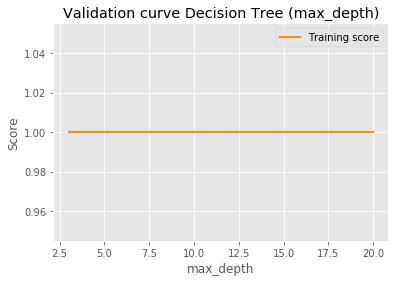

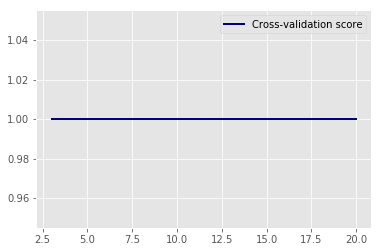

In [10]:
plot_validation_curve_lin(train_scores, test_scores, "Validation curve Decision Tree (max_depth)", "max_depth")